# New model with RNN:

In [1]:
def model(variables, t, params):

    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params
    a1 = a2 = a3 = 24.78485282457379
    g1=g2=g3  = 0.024884149937163258
    n1=n2=n3 = 5
    b1=b2=b3 = 33.82307682700831
    dm1=dm2=dm3 = 1.143402097500176
    dp1=dp2=dp3 = 0.7833664565550977

    dm1dt = -dm1*m1 + (a1 / (1 + ((1/k1) * p2)**n1)) + g1
    dp1dt = (b1*m1) - (dp1*p1)
    dm2dt = -dm2*m2 + (a2 / (1 + ((1/k2) * p3)**n2)) + g2
    dp2dt = (b2*m2) - (dp2*p2)
    dm3dt = -dm3*m3 + (a3 / (1 + ((1/k3) * p1)**n3)) + g3
    dp3dt = (b3*m3)-(dp3*p3)
    
    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

In [2]:
# Import Libraries
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import torch

from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [3]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False) #We are not specifying a batch size
        self.linear = nn.Linear(hidden_size, output_size)

                                                       #The middle value needs to be the length, in this case 1000, or input.size(0) (try with true_data)
                                                        #1 is the number of layers
                                                        #Actually prepare for sbi adds a batch_size, so x.shape is (1, 1000, 6)
    def forward(self, x):
        h = torch.zeros(1, 1000, self.hidden_size)
        gru_out, hn = self.gru(
            x, h)
        output = self.linear(gru_out[:, -1, :]) # It is outputting the last hidden state (timepoint 1000) for each GRU unit!
        return output

# Example usage
input_size = 6 #Needs to be the same as input.size(-1)
output_size = 25
hidden_size = 100
embedding_net = RNN(input_size, hidden_size, output_size)


In [11]:
# Define your prior distribution for each parameter
import numpy as np
from numpy import random


k1 = k2 = k3 = np.random.uniform((10**-2), 250)
a1 = a2 = a3 = np.random.uniform(20, 40)
g1 = g2 = g3 = np.random.uniform(0,5)
n1 = n2 = n3 = random.randint(1,5)
b1 = b2 = b3 = np.random.uniform((10**-2),50)
dm1 = dm2 = dm3 = np.random.uniform(1,3)
dp1 = dp2 = dp3 = np.random.uniform(0.7,0.8)

def prior(theta):
    # Separate parameters
    param1 = theta[..., 0]  # First parameter
    param2 = theta[..., 1]  # Second parameter
    # Define priors for each parameter
    prior_param1 = torch.distributions.Normal(0, 1).log_prob(param1).sum(dim=-1)
    prior_param2 = torch.distributions.Uniform(-1, 1).log_prob(param2).sum(dim=-1)
    # Return the joint prior
    return prior_param1 + prior_param2

BoxUniform(Uniform(low: torch.Size([3]), high: torch.Size([3])), 1)

In [4]:
# We only need a prior for k1-3
num_dim = 3
prior = utils.BoxUniform(low=10**-2 * torch.ones(num_dim), high=250 * torch.ones(num_dim))

In [5]:
#Code simulator and everything else as always
import numpy as np
from numpy import random
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#Define true parameters
true_params = np.array([
    246.96291990024542, 246.96291990024542, 246.96291990024542 # second set of odes
#    0, 0  # third set of odes
])

num_timesteps = 1000
num_trajectories = 6

#INVERSE! 6X1000!

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    traj = torch.zeros((num_timesteps, num_trajectories))
    for i in range(num_trajectories):
        for timestep in range(num_timesteps):
            traj[timestep, i] = solution[timestep][i]
    return traj

true_data = simulator(true_params)
true_data.shape

torch.Size([1000, 6])

In [6]:
true_data

tensor([[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
        [  2.3466,   4.8680,   2.3466,   6.7172,   2.3466,   5.7926],
        [  4.4394,  15.6593,   4.4394,  17.3690,   4.4394,  16.5141],
        ...,
        [  0.9443,  34.6693,   1.9822, 357.9927,  21.0713, 746.8439],
        [  1.2064,  35.5436,   1.7790, 337.1067,  21.1389, 759.2465],
        [  1.5425,  37.3237,   1.5972, 317.1701,  21.1992, 770.9217]])

NPE only

In [19]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=100)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

Running 100 simulations.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

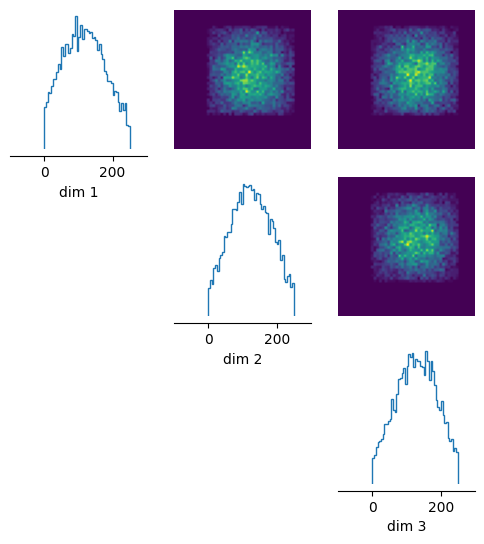

In [24]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6)
)

## Paralellise it prior to SNPE

In [8]:
# PART 1: Edited code from original sbi repos. Functions edited: simulate_for_sbi, and all the functions it contains.
#Main changes: defined simulator_seeded globally rather than within simulate_in_batches function, and re-imported torch within simulator_seeded 
#NO changes need to be made in this file

# PART 2: Essentially the unparallelised code with 2 extra arguments in the simulate_for_sbi line

##################################### PART 1 #########################################
import joblib
import contextlib
import random
import torch
import numpy as np

from torch import Tensor, split, randint, cat
from typing import Any, Callable, Optional, Tuple, Union
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm.auto import tqdm

import sbi
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os

from sbi.inference import SNLE, prepare_for_sbi
# No longer importing simulate_for_sbi from the package, we use the one defined above
from sbi import utils as utils
from sbi import analysis as analysis

def seed_all_backends(seed: Optional[Union[int, Tensor]] = None) -> None:
    if seed is None:
        seed = int(torch.randint(1_000_000, size=(1,)))
    else:
        # Cast Tensor to int (required by math.random since Python 3.11)
        seed = int(seed)

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # type: ignore
    torch.backends.cudnn.benchmark = False # type: ignore

def simulator_seeded(simulator: Callable, theta: Tensor, seed: int) -> Tensor:
    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    with torch.random.fork_rng(devices=[]):
        torch.manual_seed(seed)
        return simulator(theta)

def simulate_in_batches(simulator: Callable, theta: Tensor, sim_batch_size: int = 1, num_workers: int = 1,
                        seed: Optional[int] = None, show_progress_bars: bool = True, ) -> Tensor:

    num_sims, *_ = theta.shape
    seed_all_backends(seed)

    if num_sims == 0:
        x = torch.tensor([])
    elif sim_batch_size is not None and sim_batch_size < num_sims:
        batches = split(theta, sim_batch_size, dim=0)

        if num_workers != 1:
            batch_seeds = randint(high=1_000_000, size=(len(batches),))

            with tqdm_joblib(
                tqdm(batches, disable=not show_progress_bars,
                     desc=f"Running {num_sims} simulations in {len(batches)} batches.", total=len(batches),)) as _:
                simulation_outputs = Parallel(n_jobs=num_workers)(delayed(simulator_seeded)(simulator, batch, batch_seed)
                    for batch, batch_seed in zip(batches, batch_seeds))
        else:
            pbar = tqdm(total=num_sims, disable=not show_progress_bars, desc=f"Running {num_sims} simulations.", )

            with pbar:
                simulation_outputs = []
                for batch in batches:
                    simulation_outputs.append(simulator_seeded(simulator, batch, seed))
                    pbar.update(sim_batch_size)

        x = cat(simulation_outputs, dim=0)
    else:
        x = simulator(theta)

    return x


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()

def simulate_for_sbi(simulator: Callable, proposal: Any, num_simulations: int, num_workers: int = 1,
                     simulation_batch_size: int = 1, seed: Optional[int] = None,
                     show_progress_bar: bool = True, ) -> Tuple[Tensor, Tensor]:

    theta = proposal.sample((num_simulations,))

    x = simulate_in_batches(simulator=simulator, theta=theta, sim_batch_size=simulation_batch_size,
                            num_workers=num_workers, seed=seed, show_progress_bars=show_progress_bar,)

    return theta, x

######################################################################################################

simulation_batch_size = 200
num_simulations = 1500

# To parallelise, set number of CPUs to be used. Note: parallelise anything that has num_rounds>2 and/or num_simulations>50
# to see total available CPUs: print(os.cpu_count())

CPUs_to_use = 8

total_CPUs = os.cpu_count()
num_workers = CPUs_to_use - total_CPUs -1
# num_workers = -1 uses all cpus
# num_workers = -2 uses all cpus but one etc https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
if CPUs_to_use > total_CPUs:
    raise ValueError(f"Cannot use more CPUs than are available. Available CPUs: {total_CPUs}")

try running the same but with parallelisation

In [28]:
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="mdn", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

Running 500 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 82 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

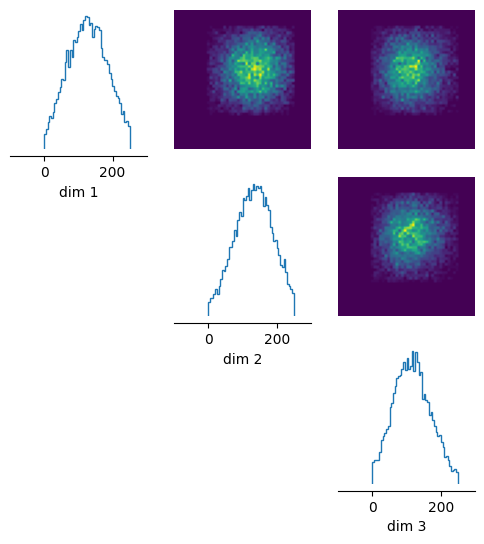

In [29]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6)
)

Multi-round SNPE

In [10]:
num_rounds = 5
num_simulations = 1000
simulation_batch_size = 200
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    simulator, prior = prepare_for_sbi(simulator, prior)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=num_simulations, simulation_batch_size=simulation_batch_size, num_workers=num_workers)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator, sample_with="mcmc")
    posteriors.append(posterior)
    proposal = posterior.set_default_x(true_data)

Running 1000 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 271 epochs.

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10100 [00:00<?, ?it/s]

Running 1000 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 18

KeyboardInterrupt: 

# When building posterior, sample_with=MCMC!!!

In [ ]:
posterior_samples = posterior.sample((10000,), x=true_data)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-100, 300], [-100, 300], [-100, 300]], figsize=(6, 6)
)